Imports

In [1]:
# ! pip install numpy 
# ! pip install qiskit
# ! pip install matplotlib

In [2]:
from qiskit import QuantumCircuit, Aer ,BasicAer, execute, transpile
from qiskit.visualization import plot_bloch_multivector, plot_histogram, plot_state_qsphere
from qiskit.quantum_info import Statevector, partial_trace, state_fidelity
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
from qiskit.providers.aer.noise import NoiseModel, amplitude_damping_error

Using the inital state |s> = |+> , which we want to teleport

In [3]:
alice_state = Statevector.from_label("+")

The circuit for teleportation

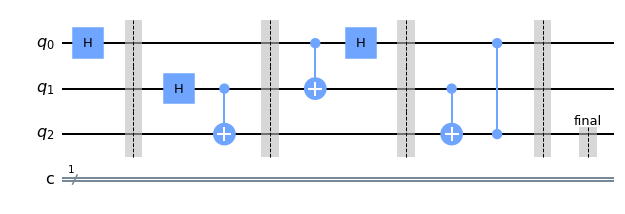

In [4]:
teleportation_circuit = QuantumCircuit(3, 1)

# Making the state alice wants to communicate
teleportation_circuit.h(0)

teleportation_circuit.barrier()

# Entanger circuit
teleportation_circuit.h(1)
teleportation_circuit.cx(1,2)

teleportation_circuit.barrier()

# Dis-Entanger circuit
teleportation_circuit.cx(0,1)
teleportation_circuit.h(0)

teleportation_circuit.barrier()

# Controlled not gates based on Alice's Results
teleportation_circuit.cx(1,2)
teleportation_circuit.cz(0,2)

teleportation_circuit.barrier()

#teleportation_circuit.measure(2,0)
teleportation_circuit.snapshot("final", snapshot_type='statevector', qubits=[2])

teleportation_circuit.draw('mpl')

Making a function for noise model

In [5]:
from qiskit.providers.aer.noise import NoiseModel, noise_model
from qiskit.providers.aer.noise.errors import pauli_error

def noisy_simulator(p):
    
    noise_model = NoiseModel()
    # Using the Bit-flip noise channel
    error_meas = pauli_error([('X',p), ('I', 1 - p)])    
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    return noise_model

In [6]:
# Initlaizing the quantum simulator and decomposing the circuit interms of the basic gates
simulator =Aer.get_backend('qasm_simulator')
basis_gates = ['rz', 'sx', 'x', 'id' ,"cx"]
quantum_circ = transpile(teleportation_circuit, basis_gates=basis_gates)

In [7]:
# Making list of noise (probability of failure) under whichwe want to teleport the state
# Making a list of fidelity to store the accuracy of our teleportations
p_noise = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
fidelity = []

for p in p_noise:
    #Simualting the circuit for each value of noise 
    
    noisy_results = execute(quantum_circ, backend=simulator, shots=10000, noise_model=noisy_simulator(p)).result()
    
    # get the state of of the circuit after teleportations circuit has been traversed
    state  = noisy_results.data(0)['snapshots']['statevector']['final']
    # encode this state as a statevector
    state_ac = Statevector(state[0], dims=(2, 2, 2))
    
    # take a partial trace to get the reduced matric rho bob has
    bob_state = partial_trace(state_ac, [0,1]).to_statevector()
    
    # find fidelity of state alice was to communicate and bob has recieved
    fidelity.append(state_fidelity(alice_state, bob_state))

Text(0.5, 0, 'Noise (p)')

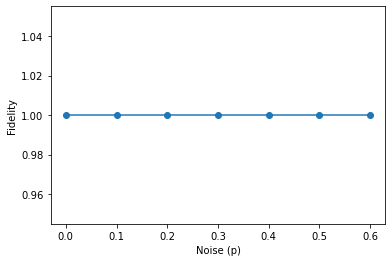

In [8]:
plt.plot(p_noise, fidelity, 'o-')
plt.ylabel("Fidelity")
plt.xlabel("Noise (p)")